In [1]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Defaulting to user installation because normal site-packages is not writeable
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [2]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import h2o
import pandas as pd
from h2o.estimators import H2OXGBoostEstimator
h2o.init(min_mem_size = "8G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\romil\AppData\Local\Temp\tmphhkc2fdj
  JVM stdout: C:\Users\romil\AppData\Local\Temp\tmphhkc2fdj\h2o_romil_started_from_python.out
  JVM stderr: C:\Users\romil\AppData\Local\Temp\tmphhkc2fdj\h2o_romil_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_romil_tfnflb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


root_path ="D:\\Vaastu\\Utilities\\"

model_vf = xgb.Booster()
model_vf.load_model(root_path + "train_model_dpth_gamma_lr_80.30.1.json")
feature_important = model_vf.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
top_features   = keys[0:600]
rel_features=top_features
rel_features.append("DPD_60_plus_12")


In [3]:
base_data=pd.read_pickle(root_path + "modelbase_12m_18m_CV.pkl")
#driverset= pd.read_pickle('driverset_18M.pkl')

rel_columns =top_features.append("DPD_60_plus_12")
hf = h2o.H2OFrame(base_data[list(set(rel_features))])


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
def calculate_woe_iv(dataset, feature_b, target):
    
    dataset[feature_b].replace([np.inf, -np.inf], np.nan, inplace = True)
     
    if dataset[feature_b].dtype in ['float64', 'int64']:
        #dataset[dataset[feature_b]< 0][feature_b] = 0
        dataset['feature'] = pd.qcut(dataset[feature_b], q = [0, .05, .1, .2,.4, .6, .8,0.9,0.95, 1],
                                     duplicates = 'drop', precision = 0).values.add_categories(['Missing', 'Others'])
    else:
        dataset['feature'] = dataset[feature_b]

    dataset['feature'].fillna('Missing', inplace = True)
    
    #print(dataset['feature'].unique())

    lst = []
    num_rows = dataset.shape[0]

    val_list = dataset['feature'].unique()
    for val in val_list:
        occ_val = dataset[dataset['feature'] == val].count()['feature']
        if occ_val < 0.005 * num_rows :
            dataset['feature'] = np.where(dataset['feature'] == val, 'Others', dataset['feature'])

    val_list = dataset['feature'].unique()
    for val in val_list:
        lst.append({
        'Feature': feature_b,
        'Value': val,
        'Min_val': dataset[dataset['feature'] == val].min()[feature_b],
        'All': dataset[dataset['feature'] == val].count()['feature'],
        'Good': dataset[(dataset['feature'] == val) & (dataset[target] == 0)].count()['feature'],
        'Bad': dataset[(dataset['feature'] == val) & (dataset[target] == 1)].count()['feature']
        })

    dset = pd.DataFrame(lst)
    dset['Event_rate'] = dset['Bad'] / dset['All']
    dset['Prop'] = dset['All'] / dset['All'].sum()
    dset['Prop_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Prop_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Prop_Good'] / dset['Prop_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV_component'] = (dset['Prop_Good'] - dset['Prop_Bad']) * dset['WoE']

    iv = dset['IV_component'].sum()

    dset = dset.sort_values(by = 'Min_val')

    return dset, iv

In [5]:
!pip install shutup


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
feat_list = base_data.columns[5:]
iv_summ=[]
for feat in feat_list:
    print(feat)
    dset, iv = calculate_woe_iv(base_data,feat , "DPD_60_plus_18")
    dset['Feature'] = feat
    iv_summ.append(iv)
    if feat == feat_list[0]:
        dset_summ= dset
    else:
        dset_summ = dset_summ.append(dset, ignore_index=True)
        
dset_summ.to_csv("Woe_table.csv")       
df_iv = pd.DataFrame(list(zip(iv_summ, feat_list)),
                 columns=['IV', 'Feature'])

df_iv.to_csv("IV_table.csv")       


In [6]:
from h2o.estimators import H2OXGBoostEstimator
hf["DPD_60_plus_12"] = hf["DPD_60_plus_12"].asfactor()
predictors = list(set(hf.columns)- set(["DPD_60_plus_12"]))
response = "DPD_60_plus_12"

# Split the dataset into a train and valid set:
train, valid = hf.split_frame(ratios=[.75], seed=1234)
train.shape, valid.shape, train[predictors].shape ,train['response'].mean()

((23422, 594), (7715, 594), (23422, 593))

In [20]:
train[response].mean() , valid[response].mean()

([0.08795149859106823], [0.09138042773817238])

In [15]:
from h2o.estimators import H2OGradientBoostingEstimator

# Set the predictors and response; set the response as a factor:


# Build and train the model:
pros_gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
pros_gbm.train(x=predictors, y=response, training_frame=train)

model_path = h2o.save_model(model=best_model, path="C:\\Users\\romil\\baseline_model", force=True)
#print model_path

# load the model
#saved_model = h2o.load_model(model_path)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
import os
os.getcwd()
model_path = h2o.save_model(model=best_model, path="C:\\Users\\romil\\baseline_model\\final_grid_model_11", force=True)


In [30]:

model_path="C:\\Users\\romil\\baseline_model\\final_grid_model_11"

saved_model = h2o.load_model(model_path)
varimp = saved_model.varimp(use_pandas=True)
varimp.to_csv("Variable_imp.csv")

In [31]:
saved_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: final_grid_model_11


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           539                    6            6            6             38            38            38

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14346380912384424
RMSE: 0.3787661668151529
LogLoss: 0.4605937931051867
Mean Per-Class Error: 0.4207970263707434
AUC: 0.6256331629799778
AUCPR: 0.3270291075995922
Gini: 0.2512663259599557

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1750516188746862
       0     1      Error    Rate
-----  ----  -----  -------  -----------------
0      7314  12098  0.6232   (12098.0/19412.0)
1      901   3225   0.2184   (901.0/4126.0)
Total  8215  15323  0.5523   (12999.0/23538.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.175052     0.331637  20
max f2                       0.172051     0.516132  21
max f0point5                 0.180267     0.318124  16
max accuracy                 0.194777     0.836435  11
max precision                0.220894     1         0
max recall                   0.170378     1         23
max specificity              0.220894     1         0
max absolute_mcc             0.194777     0.232096  11
max min_per_class_accuracy   0.177532     0.385846  19
max mean_per_class_accuracy  0.177532     0.585876  19
max tns                      0.220894     19412     0
max fns                      0.220894     3997      0
max fps                      0.166613     19412     24
max tps                      0.170378     4126      23
max tnr                      0.220894     1         0
max fnr                      0.220894     0.968735  0
max fpr                      0.166613     1         24
max tpr                      0.170378     1         23

Gains/Lift Table: Avg response rate: 17.53 %, avg score: 17.54 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.0118957                   0.209867           5.21582   5.21582            0.914286         0.215826  0.914286                    0.215826            0.0620456       0.0620456                  421.582    421.582            0.0608092
2        0.0203926                   0.187817           3.4514    4.48064            0.605            0.198123  0.785417                    0.20845             0.0293262       0.0913718                  245.14     348.064            0.0860658
3        0.21187                     0.178087           1.32652   1.63011            0.232527         0.178202  0.285743                    0.181114            0.253999        0.345371                   32.6521    63.0106            0.161876
4        0.65099                     0.175052           0.993483  1.20068            0.174149         0.175234  0.210468                    0.177148            0.436258        0.781629                   -0.651723  20.0677            0.158406
5        0.996134                    0.172051           0.631292  1.00339            0.11066          0.172051  0.175886                    0.175382            0.

In [17]:

# Eval performance:
perf = pros_gbm.model_performance()

# Generate predictions on a test set (if necessary):


# Extract feature interactions:
feature_interactions = pros_gbm.feature_interaction()


In [49]:
pred = pros_gbm.predict(valid)
valid['Default_Prob'] = pred['p1']
pred = pros_gbm.predict(train)

train['Default_Prob'] = pred['p1']

train_pd= h2o.as_list(train[['Default_Prob','DPD_60_plus_18']])
val_pd= h2o.as_list(valid[['Default_Prob','DPD_60_plus_18']])


train_pd['decile'] = pd.qcut(train_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))
val_pd['decile'] = pd.qcut(val_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))


df = train_pd.groupby('decile').agg({ 'Default_Prob' : [min,max,'count'],'DPD_60_plus_18' : sum }   ).reset_index()
df.columns = ['Decile' , 'From','To','Obs_train','Bads_train' ]
df['Bad_rate_train'] = df['Bads_train']/df['Obs_train']
df['Goods_train'] = df['Obs_train'] - df['Bads_train']
df['Good_Rate_train'] = df['Goods_train']/df['Obs_train']
df['Cum_Approval_rate_train'] = (df.Obs_train.cumsum() / df.Obs_train.sum()) * 100
df['Cum_Bads_train'] = df.Bads_train.cumsum() 
df['Cum_Approvals_train'] = df.Obs_train.cumsum() 
df['Cum_BadRate_train'] = df['Cum_Bads_train'] / df['Cum_Approvals_train']




df_v = val_pd.groupby('decile').agg({ 'Default_Prob' : ['count'],'DPD_60_plus_18' : sum }   ).reset_index()
df_v.columns = ['Decile' , 'Obs_val','Bads_val' ]
df_v['Bad_rate_val'] = df_v['Bads_val']/df_v['Obs_val']
df_v['Goods_val'] = df_v['Obs_val'] - df_v['Bads_val']
df_v['Good_Rate_val'] = df_v['Goods_val']/df_v['Obs_val']
df_v['Cum_Approval_rate_val'] = (df_v.Obs_val.cumsum() / df_v.Obs_val.sum()) * 100
df_v['Cum_Bads_val'] = df_v.Bads_val.cumsum() 
df_v['Cum_Approvals_val'] = df_v.Obs_val.cumsum() 
df_v['Cum_BadRate_val'] = df_v['Cum_Bads_val'] / df_v['Cum_Approvals_val']




df_comb=df.merge(df_v , on = "Decile", how ="left")
df_comb = df_comb.sort_values(by=['Decile'])
df_comb.to_csv("Benchmark_model_stats.csv")
df_comb

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,Decile,From,To,Obs_train,Bads_train,Bad_rate_train,Goods_train,Good_Rate_train,Cum_Approval_rate_train,Cum_Bads_train,...,Cum_BadRate_train,Obs_val,Bads_val,Bad_rate_val,Goods_val,Good_Rate_val,Cum_Approval_rate_val,Cum_Bads_val,Cum_Approvals_val,Cum_BadRate_val
0,20,0.076548,0.111540,1177,25,0.021240,1152,0.978760,5.000425,25,...,0.021240,388,7,0.018041,381,0.981959,5.007744,7,388,0.018041
1,19,0.111540,0.117662,1177,34,0.028887,1143,0.971113,10.000850,59,...,0.025064,387,26,0.067183,361,0.932817,10.002581,33,775,0.042581
2,18,0.117662,0.123618,1177,62,0.052676,1115,0.947324,15.001275,121,...,0.034268,388,20,0.051546,368,0.948454,15.010325,53,1163,0.045572
3,17,0.123618,0.127510,1177,101,0.085811,1076,0.914189,20.001699,222,...,0.047154,387,41,0.105943,346,0.894057,20.005163,94,1550,0.060645
4,16,0.127510,0.132589,1177,103,0.087511,1074,0.912489,25.002124,325,...,0.055225,387,47,0.121447,340,0.878553,25.000000,141,1937,0.072793
5,15,0.132589,0.138420,1177,112,0.095157,1065,0.904843,30.002549,437,...,0.061880,388,34,0.087629,354,0.912371,30.007744,175,2325,0.075269
6,14,0.138431,0.144551,1176,111,0.094388,1065,0.905612,34.998725,548,...,0.066521,387,34,0.087855,353,0.912145,35.002581,209,2712,0.077065
7,13,0.144551,0.149373,1177,107,0.090909,1070,0.909091,39.999150,655,...,0.069570,387,32,0.082687,355,0.917313,39.997419,241,3099,0.077767
8,12,0.149373,0.152061,1177,141,0.119796,1036,0.880204,44.999575,796,...,0.075151,388,58,0.149485,330,0.850515,45.005163,299,3487,0.085747
9,11,0.152061,0.155590,1177,150,0.127443,1027,0.872557,50.000000,946,...,0.080381,387,59,0.152455,328,0.847545,50.000000,358,3874,0.092411


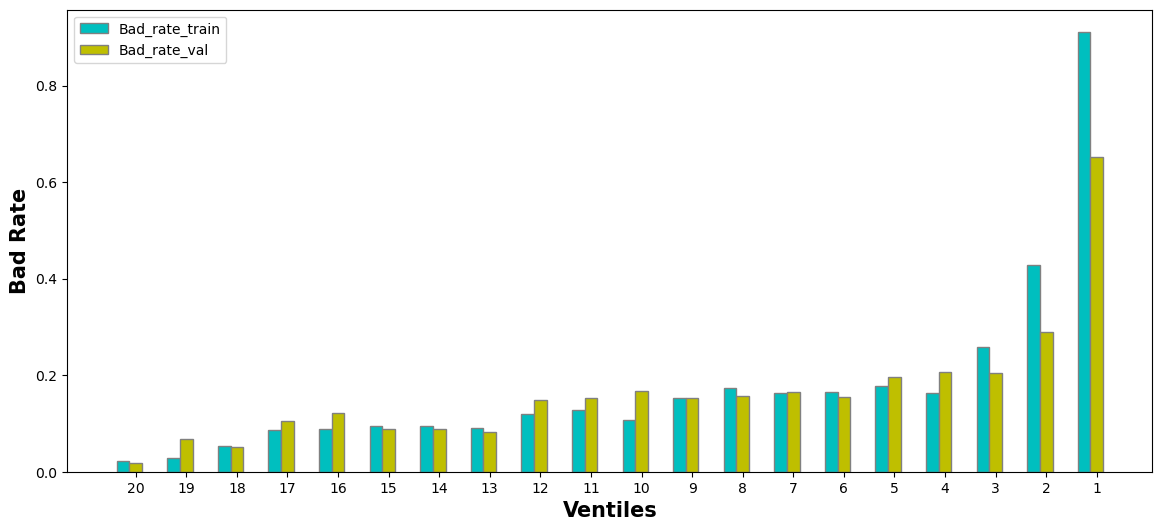

In [47]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(14, 6))
 
# set height of bar
bd_tr = df_comb['Bad_rate_train']
bd_vl = df_comb['Bad_rate_val']
 
# Set position of bar on X axis
br1 = np.arange(len(bd_tr))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, bd_tr, color ='c', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_train')
plt.bar(br2, bd_vl, color ='y', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_val')
 
# Adding Xticks
plt.xlabel('Ventiles', fontweight ='bold', fontsize = 15)
plt.ylabel('Bad Rate', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(bd_tr))],
        df_comb['Decile'])
 
plt.legend()
plt.show()

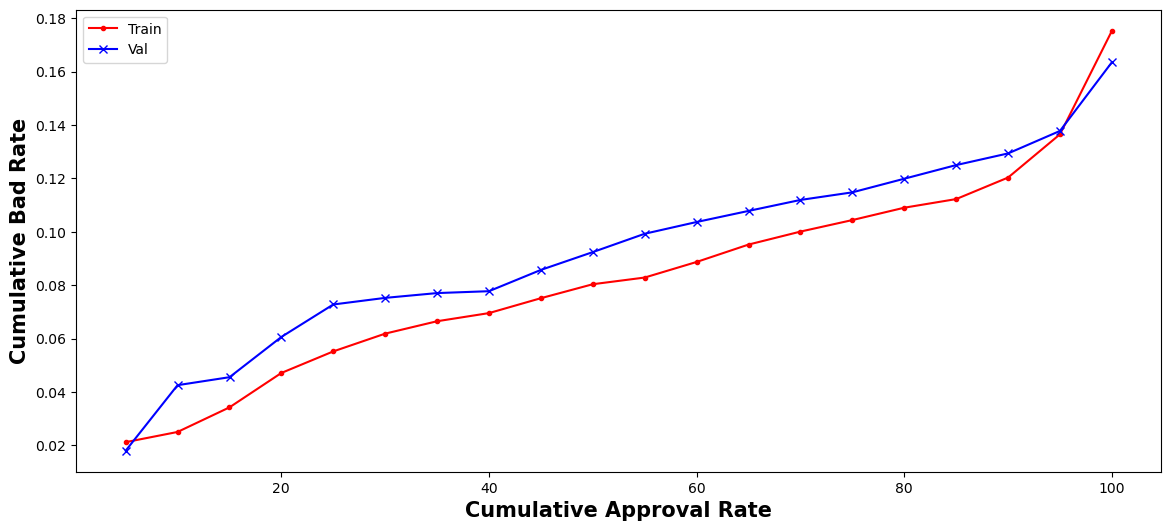

In [48]:
import matplotlib.pyplot as plt
fig = plt.subplots(figsize =(14, 6))

plt.plot(df_comb['Cum_Approval_rate_train'], df_comb['Cum_BadRate_train'], '.r-' , label= "Train") 
plt.plot(df_comb['Cum_Approval_rate_val'], df_comb['Cum_BadRate_val'], 'xb-', label= "Val") 

# Adding Xticks
plt.xlabel('Cumulative Approval Rate', fontweight ='bold', fontsize = 15)
plt.ylabel('Cumulative Bad Rate', fontweight ='bold', fontsize = 15)

 
plt.legend()
plt.show()

In [7]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(6,10,1)),
                #'sample_rate': [x/100. for x in range(20,101)],
                #'col_sample_rate' : [x/100. for x in range(20,101)],
                #'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                #'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                #'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(7,12)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [8]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch


gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=1000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 1234,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors, 
           y=response,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train,
           validation_frame = valid)

print(final_grid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing logloss
    histogram_type    max_depth    min_split_improvement    nbins    nbins_cats    model_ids            logloss
--  ----------------  -----------  -----------------------  -------  ------------  -------------------  ---------
    QuantilesGlobal   9            1e-06                    64       1024          final_grid_model_10  0.234221
    UniformAdaptive   9            1e-08                    128      512           final_grid_model_4   0.240399
    UniformAdaptive   9            1e-08                    128      128           final_grid_model_7   0.240399
    QuantilesGlobal   8            1e-06                    512      1024          final_grid_model_8   0.245089
    UniformAdaptive   8            1e-06                    32       2048          final_grid_model_12  0.246494
    RoundRobin        7            0.0001           

In [9]:
sorted_final_grid = final_grid.get_grid(sort_by='logloss',decreasing=False)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(valid)
print(performance_best_model.logloss())
import os
os.getcwd()
root_path ="D:\\Vaastu\\Utilities\\"


model_path = h2o.save_model(model=best_model, path=root_path + "best_model12M", force=True)
#print(sorted_final_grid)

0.23422073556200862


In [10]:
params_list = []
for key, value in best_model.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))


In [11]:
# save the model


#print model_path

# load the model
#saved_model = h2o.load_model(model_path)


In [17]:
pros_gbm = h2o.load_model(root_path + "best_model12M\\final_grid_model_10")


pred = pros_gbm.predict(valid)
valid['Default_Prob'] = pred['p1']
pred = pros_gbm.predict(train)

train['Default_Prob'] = pred['p1']

train_pd= h2o.as_list(train[['Default_Prob','DPD_60_plus_12']])
val_pd= h2o.as_list(valid[['Default_Prob','DPD_60_plus_12']])


train_pd['decile'] = pd.qcut(train_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))
val_pd['decile'] = pd.qcut(val_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))


df = train_pd.groupby('decile').agg({ 'Default_Prob' : [min,max,'count'],'DPD_60_plus_12' : sum }   ).reset_index()
df.columns = ['Decile' , 'From','To','Obs_train','Bads_train' ]
df['Bad_rate_train'] = df['Bads_train']/df['Obs_train']
df['Goods_train'] = df['Obs_train'] - df['Bads_train']
df['Good_Rate_train'] = df['Goods_train']/df['Obs_train']
df['Cum_Approval_rate_train'] = (df.Obs_train.cumsum() / df.Obs_train.sum()) * 100
df['Cum_Bads_train'] = df.Bads_train.cumsum() 
df['Cum_Approvals_train'] = df.Obs_train.cumsum() 
df['Cum_BadRate_train'] = df['Cum_Bads_train'] / df['Cum_Approvals_train']




df_v = val_pd.groupby('decile').agg({ 'Default_Prob' : ['count'],'DPD_60_plus_12' : sum }   ).reset_index()
df_v.columns = ['Decile' , 'Obs_val','Bads_val' ]
df_v['Bad_rate_val'] = df_v['Bads_val']/df_v['Obs_val']
df_v['Goods_val'] = df_v['Obs_val'] - df_v['Bads_val']
df_v['Good_Rate_val'] = df_v['Goods_val']/df_v['Obs_val']
df_v['Cum_Approval_rate_val'] = (df_v.Obs_val.cumsum() / df_v.Obs_val.sum()) * 100
df_v['Cum_Bads_val'] = df_v.Bads_val.cumsum() 
df_v['Cum_Approvals_val'] = df_v.Obs_val.cumsum() 
df_v['Cum_BadRate_val'] = df_v['Cum_Bads_val'] / df_v['Cum_Approvals_val']




df_comb=df.merge(df_v , on = "Decile", how ="left")
df_comb = df_comb.sort_values(by=['Decile'])
df_comb.to_csv("Benchmark_model_stats_12M.csv")
df_comb

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,Decile,From,To,Obs_train,Bads_train,Bad_rate_train,Goods_train,Good_Rate_train,Cum_Approval_rate_train,Cum_Bads_train,...,Cum_BadRate_train,Obs_val,Bads_val,Bad_rate_val,Goods_val,Good_Rate_val,Cum_Approval_rate_val,Cum_Bads_val,Cum_Approvals_val,Cum_BadRate_val
0,20,0.017323,0.031068,1172,1,0.000853,1171,0.999147,5.003843,1,...,0.000853,386,3,0.007772,383,0.992228,5.003240,3,386,0.007772
1,19,0.031068,0.033721,1171,1,0.000854,1170,0.999146,10.003416,2,...,0.000854,386,4,0.010363,382,0.989637,10.006481,7,772,0.009067
2,18,0.033731,0.036670,1171,9,0.007686,1162,0.992314,15.002989,11,...,0.003130,386,10,0.025907,376,0.974093,15.009721,17,1158,0.014680
3,17,0.036675,0.039865,1171,7,0.005978,1164,0.994022,20.002562,18,...,0.003842,385,10,0.025974,375,0.974026,20.000000,27,1543,0.017498
4,16,0.039867,0.043524,1171,6,0.005124,1165,0.994876,25.002135,24,...,0.004098,386,14,0.036269,372,0.963731,25.003240,41,1929,0.021255
5,15,0.043526,0.046717,1171,10,0.008540,1161,0.991460,30.001708,34,...,0.004838,386,8,0.020725,378,0.979275,30.006481,49,2315,0.021166
6,14,0.046717,0.050059,1171,12,0.010248,1159,0.989752,35.001281,46,...,0.005611,385,15,0.038961,370,0.961039,34.996760,64,2700,0.023704
7,13,0.050073,0.053377,1171,12,0.010248,1159,0.989752,40.000854,58,...,0.006191,386,9,0.023316,377,0.976684,40.000000,73,3086,0.023655
8,12,0.053377,0.056987,1171,26,0.022203,1145,0.977797,45.000427,84,...,0.007970,386,17,0.044041,369,0.955959,45.003240,90,3472,0.025922
9,11,0.056987,0.061179,1171,31,0.026473,1140,0.973527,50.000000,115,...,0.009820,386,22,0.056995,364,0.943005,50.006481,112,3858,0.029031


In [18]:
pros_gbm

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: final_grid_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    600                600                         399170                 9            9            9             13            97            47.785

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.048137817113156525
RMSE: 0.21940332065207338
LogLoss: 0.18459600002508464
Mean Per-Class Error: 0.1902335196424465
AUC: 0.9196866680058865
AUCPR: 0.7645091910051769
Gini: 0.839373336011773

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1495536549165582
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      21043  319   0.0149   (319.0/21362.0)
1      753    1307  0.3655   (753.0/2060.0)
Total  21796  1626  0.0458   (1072.0/23422.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.149554     0.70917   217
max f2                       0.107781     0.701915  251
max f0point5                 0.218261     0.814416  183
max accuracy                 0.209196     0.956323  187
max precision                0.974388     1         0
max recall                   0.0307778    1         385
max specificity              0.974388     1         0
max absolute_mcc             0.190812     0.693878  195
max min_per_class_accuracy   0.0864647    0.834466  277
max mean_per_class_accuracy  0.0971989    0.84805   263
max tns                      0.974388     21362     0
max fns                      0.974388     2058      0
max fps                      0.0182294    21362     399
max tps                      0.0307778    2060      385
max tnr                      0.974388     1         0
max fnr                      0.974388     0.999029  0
max fpr                      0.0182294    1         399
max tpr                      0.0307778    1         385

Gains/Lift Table: Avg response rate:  8.80 %, avg score:  8.80 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100333                   0.776549           11.3699     11.3699            1                0.85809    1                           0.85809             0.114078        0.114078                   1036.99   1036.99            0.114078
2        0.0201093                   0.618844           11.3699     11.3699            1                0.697009   1                           0.777379            0.114563        0.228641                   1036.99   1036.99            0.228641
3        0.0300572                   0.455301           11.2235     11.3215            0.987124         0.534853   0.995739                    0.697111            0.11165         0.340291                   1022.35   1032.15            0.340151
4        0.0400051                   0.311691           10.3451     11.0787            0.909871         0.380927   0.974386                    0.618487            0.102913        0.443204                   934.515   1007.87            0.44208
5        0.0500384                   0.220125           8.90239     10.6423            0.782979         0.261062   0.936007                

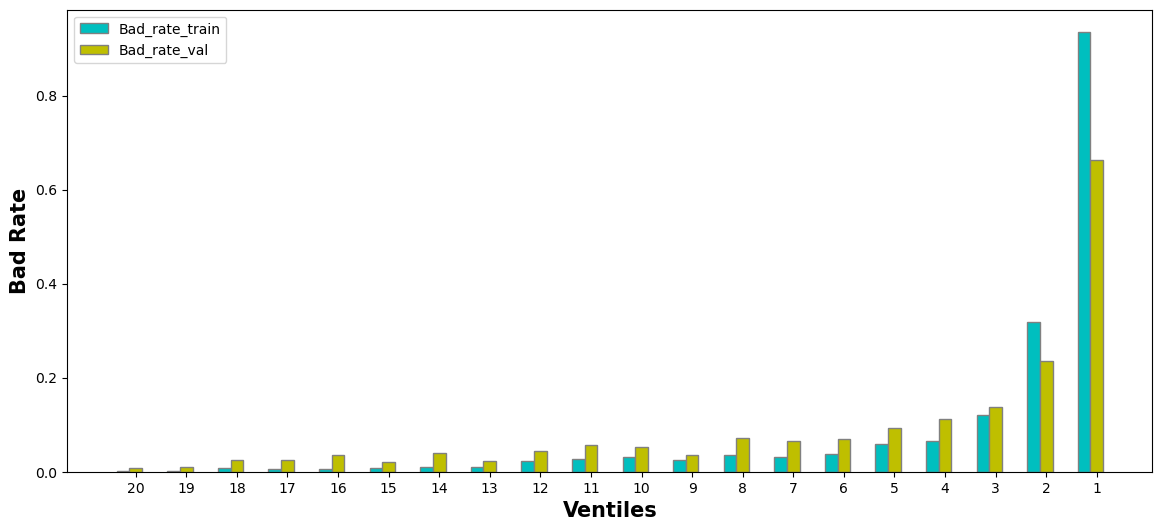

In [21]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(14, 6))
 
# set height of bar
bd_tr = df_comb['Bad_rate_train']
bd_vl = df_comb['Bad_rate_val']
 
# Set position of bar on X axis
br1 = np.arange(len(bd_tr))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, bd_tr, color ='c', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_train')
plt.bar(br2, bd_vl, color ='y', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_val')
 
# Adding Xticks
plt.xlabel('Ventiles', fontweight ='bold', fontsize = 15)
plt.ylabel('Bad Rate', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(bd_tr))],
        df_comb['Decile'])
 
plt.legend()
plt.show()

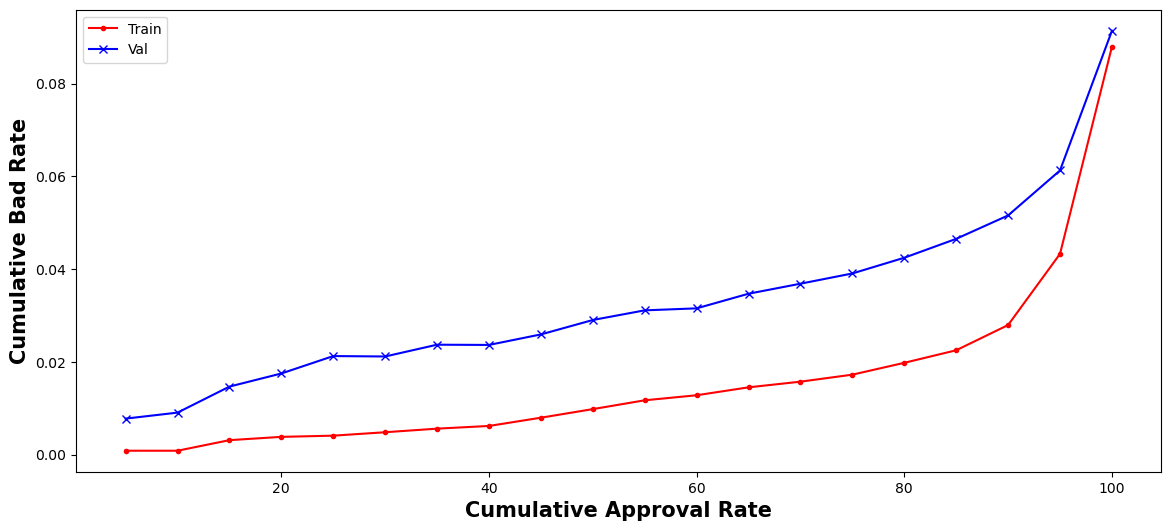

In [22]:
import matplotlib.pyplot as plt
fig = plt.subplots(figsize =(14, 6))

plt.plot(df_comb['Cum_Approval_rate_train'], df_comb['Cum_BadRate_train'], '.r-' , label= "Train") 
plt.plot(df_comb['Cum_Approval_rate_val'], df_comb['Cum_BadRate_val'], 'xb-', label= "Val") 

# Adding Xticks
plt.xlabel('Cumulative Approval Rate', fontweight ='bold', fontsize = 15)
plt.ylabel('Cumulative Bad Rate', fontweight ='bold', fontsize = 15)

 
plt.legend()
plt.show()

In [24]:

saved_model = h2o.load_model(root_path + "best_model12M\\final_grid_model_10")
varimp = saved_model.varimp(use_pandas=True)
varimp.to_csv("Variable_imp_12M.csv")